# Nonlinear Online Estimation

In this demo we consider a model for the spead of a virus in a population. We are interested in estimating the spread parameter from daily observations of the number of infected individuals. The spread parameter indicates how many others are (on average) infected by one infected individual. 

In [1]:
using ForneyLab
using PyPlot

## Generate Data

We start by generating a toy dataset for a virus with a spread parameter $a$. Here, $y$ represents the measured number of infected individuals, and $x$ a latent state.

In [2]:
# Generate toy dataset
T = 15
x_0_data = 0.6
a_data = 1.2

x_data = Vector{Float64}(undef, T)
y_data = Vector{Float64}(undef, T)

x_t_min_data = x_0_data
for t=1:T
    x_data[t] = a_data*x_t_min_data
    y_data[t] = ceil(x_data[t])
    
    x_t_min_data = x_data[t]
end    
;

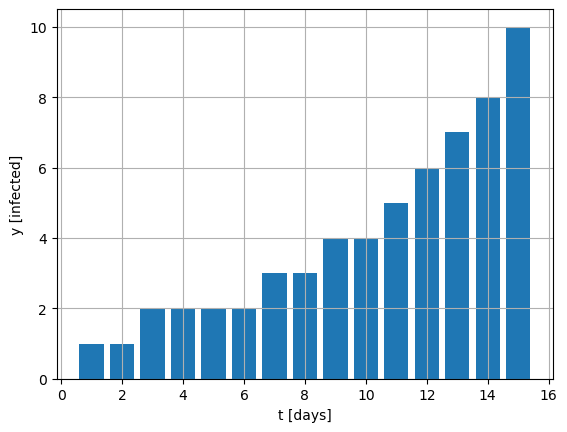

In [3]:
# Inspect data
bar(1:T, y_data)
grid("on")
xlabel("t [days]")
ylabel("y [infected]")
;

## Define Model

We define a state-space model, where we specify the state transition by a `Nonlinear` node. We may optionally define an inverse function for each of the arguments of the forward transition `g`. It is important that the function arguments, and the order in which these functions are passed to the `Nonlinear` node specification, follow the order: `out`, `in1`, `in2`, etc. In our specific case, we have `x_t`, `x_t_min`, `a`, with corresponding functions `g`, `g_inv_x_t_min`, `g_inv_a`, respectively. If an inverse function is unavailable, `nothing` may be substituted. In this case, ForneyLab will attempt to compute the backward message by an RTS-smoother. However, in the message-passing context this procedure can be unstable, and it is advised to provide an inverse function whenever possible.

In [4]:
fg = FactorGraph()

# Specify forward transition and inverse functions
g(x_t_min::Float64, a::Float64) = a*x_t_min
g_inv_x_t_min(x_t::Float64, a::Float64) = x_t/a
g_inv_a(x_t::Float64, x_t_min::Float64) = x_t/x_t_min

@RV x_t_min ~ GaussianMeanVariance(placeholder(:m_x_t_min), placeholder(:v_x_t_min))
@RV a ~ GaussianMeanVariance(placeholder(:m_a_t_min), placeholder(:v_a_t_min))
@RV x_t ~ Nonlinear(x_t_min, a; g=g, g_inv=[g_inv_x_t_min, g_inv_a])
@RV y_t ~ GaussianMeanVariance(x_t, 0.2)
placeholder(y_t, :y_t)
;

## Derive Algorithm

The message passing algorithm, including a procedure for evaluating the free energy, is automatically derived.

In [5]:
algo = sumProductAlgorithm([x_t, a], free_energy=true)
code = algorithmSourceCode(algo, free_energy=true)
;

In [6]:
println(code)

begin

function step!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 6))

messages[1] = ruleSPGaussianMeanVarianceOutNPP(nothing, Message(Univariate, PointMass, m=data[:m_x_t_min]), Message(Univariate, PointMass, m=data[:v_x_t_min]))
messages[2] = ruleSPGaussianMeanVarianceOutNPP(nothing, Message(Univariate, PointMass, m=data[:m_a_t_min]), Message(Univariate, PointMass, m=data[:v_a_t_min]))
messages[3] = ruleSPGaussianMeanVarianceMPNP(Message(Univariate, PointMass, m=data[:y_t]), nothing, Message(Univariate, PointMass, m=0.2))
messages[4] = ruleSPNonlinearUTInGX(g, g_inv_x_t_min, messages[3], nothing, messages[2])
messages[5] = ruleSPNonlinearUTOutNGX(g, nothing, messages[1], messages[2])
messages[6] = ruleSPNonlinearUTInGX(g, g_inv_a, messages[3], messages[1], nothing)

marginals[:a] = messages[2].dist * messages[6].dist
marginals[:x_t] = messages[5].dist * messages[3].dist
marginals[:x_t_min] = messages[1].dist * messages[4].dist
marginals[:x_t_mi

In [7]:
eval(Meta.parse(code))
;

## Execute Algorithm

We execute the algorithm in an online fashion, where after each timestep the posteriors for the state and spread parameters are used as priors for the next timestep.

In [8]:
# Prior statistics
m_x_0 = 0.6
v_x_0 = 0.5
m_a_0 = 1.0
v_a_0 = 0.5

F = Vector{Float64}(undef, T)
m_x = Vector{Float64}(undef, T)
v_x = Vector{Float64}(undef, T)
m_a = Vector{Float64}(undef, T)
v_a = Vector{Float64}(undef, T)

# Execute online algorithm
m_x_t_min = m_x_0
v_x_t_min = v_x_0
m_a_t_min = m_a_0
v_a_t_min = v_a_0
for t=1:T
    data = Dict(:y_t => y_data[t],
                :m_x_t_min => m_x_t_min,
                :v_x_t_min => v_x_t_min,
                :m_a_t_min => m_a_t_min,
                :v_a_t_min => v_a_t_min)

    marginals = step!(data) # Infer posteriors
    F[t] = freeEnergy(data, marginals) # Evaluate free energy
    
    # Extract posterior statistics
    (m_x_t, v_x_t) = ForneyLab.unsafeMeanCov(marginals[:x_t])
    (m_a_t, v_a_t) = ForneyLab.unsafeMeanCov(marginals[:a])
    
    # Reset for next step
    m_x_t_min = m_x[t] = m_x_t
    v_x_t_min = v_x[t] = v_x_t
    m_a_t_min = m_a[t] = m_a_t
    v_a_t_min = v_a[t] = v_a_t
end

## Inspect Results

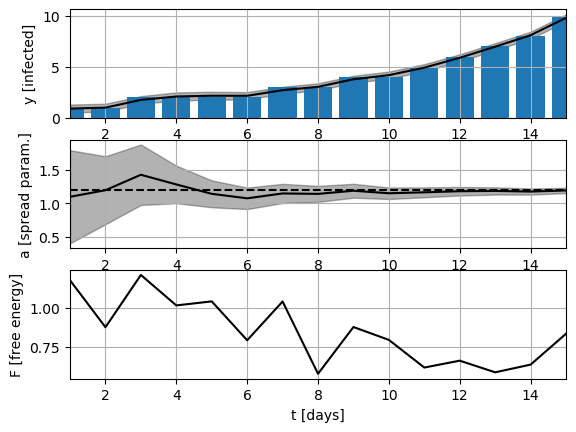

In [9]:
subplot(3,1,1)
bar(1:T, y_data)
plot(1:T, m_x, color="black")
fill_between(1:T, m_x.-sqrt.(v_x), m_x.+sqrt.(v_x), color="black", alpha=0.3)
grid("on")
xlim(1,T)
ylabel("y [infected]")

subplot(3,1,2)
plot(1:T, m_a, color="black")
fill_between(1:T, m_a.-sqrt.(v_a), m_a.+sqrt.(v_a), color="black", alpha=0.3)
plot(1:T, a_data*ones(T), color="black", linestyle="dashed")
grid("on")
xlim(1,T)
ylabel("a [spread param.]")

subplot(3,1,3)
plot(1:T, F, color="black")
grid("on")
xlim(1,T)
xlabel("t [days]")
ylabel("F [free energy]")
;